Mounting Google Drive For Data Access

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


Creating Data Generator for Data Augmentation

In [2]:
import tensorflow as tf 
from keras.applications.resnet50 import preprocess_input

datagen = tf.keras.preprocessing.image.ImageDataGenerator( 
                                                          rescale = 1./255., 
                                                          rotation_range = 8, 
                                                          width_shift_range = 0.2, 
                                                          height_shift_range = 0.2,
                                                          shear_range = 0.2, 
                                                          zoom_range = 0.2,
                                                          brightness_range = [0.5,1.5],
                                                          horizontal_flip = True,
                                                          fill_mode = 'nearest',
                                                          dtype = None,                                                      
                                                          validation_split = 0.15)


Validation and Training Sets

In [3]:
dire = '/content/gdrive/MyDrive/is_eye_infection'

train_generator = datagen.flow_from_directory(
    dire,
    subset="training",
    batch_size=32,
    class_mode='categorical',     
    shuffle=True,                      
    target_size=(150,150)
)

valid_generator = datagen.flow_from_directory(
    dire,
    subset="validation",
    shuffle=True,
    batch_size=32,
    class_mode='categorical',                           
    target_size=(150,150)
)

Found 494 images belonging to 2 classes.
Found 86 images belonging to 2 classes.


In [4]:
for image_batch, label_batch in train_generator:
  break
image_batch.shape, label_batch.shape

((32, 150, 150, 3), (32, 2))

Extracting and Saving Labels

In [5]:
label_batch[0:5]
print(train_generator.class_indices)
labels = '\n'.join(sorted(train_generator.class_indices.keys()))
with open('labels.txt', 'w') as f:
 f.write(labels)
!cat labels.txt

{'eye': 0, 'not_eye': 1}
eye
not_eye

In [6]:
import os
import urllib.request

#urllib.request.urlretrieve('https://github.com/fchollet/deep-learning-models/releases/download/v0.1/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5',
                           #'vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5')

os.listdir()



['.config', 'gdrive', 'labels.txt', 'sample_data']

Initializing Mobile Net V2 Pre-trained Model

In [7]:
from keras.applications.resnet50 import ResNet50
from keras import layers
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout
from keras.applications.vgg16 import VGG16 
from tensorflow.keras.applications.inception_v3 import InceptionV3

from tensorflow.keras import layers 
from tensorflow.keras import Model 

from tensorflow.keras.applications import ResNet50
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Flatten, GlobalAveragePooling2D

from keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications import MobileNetV2

mobileNet = MobileNetV2(
    input_shape = (150,150,3), 
    weights = 'imagenet', 
    include_top = False,
)





9412608/9406464 [==============================] - 0s 0us/step


Freezing Layers in Mobile Net V2 Model

In [9]:
for layer in mobileNet.layers:
    layer.trainable = False

Creating Custom Architecture on Top of MobileNetV2

In [13]:
from keras import layers
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras import regularizers


model = Sequential()


## Inception V3
model.add(mobileNet)
model.add(Flatten())
#model.add(GlobalAveragePooling2D())
model.add(Dense(32, activation='relu'))
model.add(Dropout(rate=0.4))
model.add(Dense(2, activation = 'softmax'))

Adjusting Adam Optimizer and Compiling Model

In [14]:
opt = tf.keras.optimizers.Adam(learning_rate=0.00001)

model.compile(optimizer=opt, loss="categorical_crossentropy", metrics=["accuracy"])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 5, 5, 1280)        2257984   
_________________________________________________________________
flatten_1 (Flatten)          (None, 32000)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 32)                1024032   
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 66        
Total params: 3,282,082
Trainable params: 1,024,098
Non-trainable params: 2,257,984
_________________________________________________________________


Training for 10 Epochs

In [15]:
hist= model.fit(train_generator, validation_data = valid_generator, epochs = 10)

Epoch 1/10
 4/16 [======>.......................] - ETA: 1:43 - loss: 1.4821 - accuracy: 0.4941

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


16/16 [==============================] - 136s 8s/step - loss: 1.3270 - accuracy: 0.5248 - val_loss: 0.8572 - val_accuracy: 0.6512
Epoch 2/10
16/16 [==============================] - 5s 345ms/step - loss: 0.7823 - accuracy: 0.6555 - val_loss: 0.4048 - val_accuracy: 0.8140
Epoch 3/10
16/16 [==============================] - 5s 343ms/step - loss: 0.5555 - accuracy: 0.7181 - val_loss: 0.3645 - val_accuracy: 0.8372
Epoch 4/10
16/16 [==============================] - 5s 341ms/step - loss: 0.4539 - accuracy: 0.7968 - val_loss: 0.2438 - val_accuracy: 0.9070
Epoch 5/10
16/16 [==============================] - 6s 349ms/step - loss: 0.3928 - accuracy: 0.8115 - val_loss: 0.2192 - val_accuracy: 0.9419
Epoch 6/10
16/16 [==============================] - 6s 350ms/step - loss: 0.3329 - accuracy: 0.8598 - val_loss: 0.1917 - val_accuracy: 0.9535
Epoch 7/10
16/16 [==============================] - 5s 344ms/step - loss: 0.3034 - accuracy: 0.8528 - val_loss: 0.1563 - val_accuracy: 0.9535
Epoch 8/10
16/16 [

Final Stats

In [16]:
final_loss, final_accuracy = model.evaluate(valid_generator)
print("Final Validation loss: {:.2f}".format(final_loss))
print("Final Validation accuracy: {:.2f}%".format(final_accuracy * 100))

final_loss, final_accuracy = model.evaluate(train_generator)
print("Final training loss: {:.2f}".format(final_loss))
print("Final training accuracy: {:.2f}%".format(final_accuracy * 100))

3/3 [==============================] - 1s 340ms/step - loss: 0.1156 - accuracy: 0.9535
Final Validation loss: 0.12
Final Validation accuracy: 95.35%


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


16/16 [==============================] - 4s 263ms/step - loss: 0.1162 - accuracy: 0.9615
Final training loss: 0.12
Final training accuracy: 96.15%


Saving Model

In [17]:
model.save('/content/gdrive/MyDrive/Infections/is_eye_infection_model.h5')

Prediction on Validation Set

In [18]:
import numpy as np

val_image_batch, val_label_batch = next(iter(valid_generator))
true_label_ids = np.argmax(val_label_batch, axis=-1)
print("Validation batch shape:", val_image_batch.shape)

Validation batch shape: (32, 150, 150, 3)


In [19]:
dataset_labels = sorted(train_generator.class_indices.items(), key=lambda pair:pair[1])
dataset_labels = np.array([key.title() for key, value in dataset_labels])
print(dataset_labels)

['Eye' 'Not_Eye']


In [20]:
tf_model_predictions = model.predict(val_image_batch)
print("Prediction results shape:", tf_model_predictions.shape)
print(tf_model_predictions)
predicted_ids = np.argmax(tf_model_predictions, axis=-1)
predicted_labels = dataset_labels[predicted_ids]
print(predicted_labels)

Prediction results shape: (32, 2)
[[7.71700501e-01 2.28299528e-01]
 [5.81487967e-03 9.94185150e-01]
 [9.80841219e-01 1.91588625e-02]
 [8.85994256e-01 1.14005685e-01]
 [8.26508939e-01 1.73491091e-01]
 [9.98354614e-01 1.64536107e-03]
 [9.98350620e-01 1.64943445e-03]
 [4.40468699e-01 5.59531271e-01]
 [2.71253358e-03 9.97287512e-01]
 [9.90112007e-01 9.88795515e-03]
 [1.07760336e-02 9.89223897e-01]
 [9.93703187e-01 6.29675202e-03]
 [9.87159967e-01 1.28400763e-02]
 [9.88736570e-01 1.12634562e-02]
 [9.95965004e-01 4.03499883e-03]
 [9.93430793e-01 6.56923233e-03]
 [4.47818600e-02 9.55218136e-01]
 [9.92423177e-01 7.57685071e-03]
 [9.94809151e-01 5.19078597e-03]
 [1.71822473e-01 8.28177571e-01]
 [3.85791808e-01 6.14208221e-01]
 [9.73830283e-01 2.61697304e-02]
 [9.96231258e-01 3.76872788e-03]
 [4.09728229e-01 5.90271771e-01]
 [1.40524907e-02 9.85947490e-01]
 [9.05212045e-01 9.47879478e-02]
 [1.22473482e-02 9.87752676e-01]
 [5.80172598e-01 4.19827372e-01]
 [9.99505162e-01 4.94849402e-04]
 [1.52008

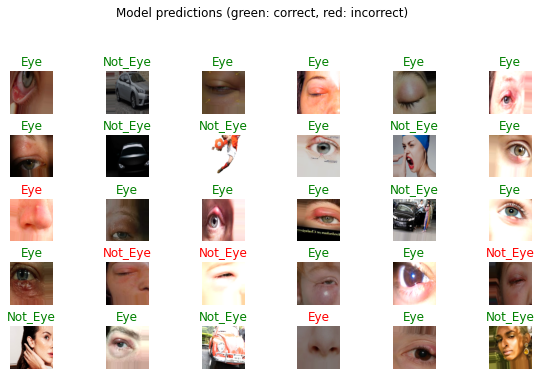

In [21]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range((len(predicted_labels)-2)):
  plt.subplot(8,6,n+1)
  plt.imshow(val_image_batch[n])
  color = "green" if predicted_ids[n] == true_label_ids[n] else "red"
  plt.title(predicted_labels[n].title(), color=color)
  plt.axis('off')
_ = plt.suptitle("Model predictions (green: correct, red: incorrect)")

Testing Model

In [ ]:
from keras.preprocessing.image import load_img
 
image = load_img('/content/gdrive/MyDrive/Infections/Test Images/Cell.jpeg', target_size=(150,150))


In [ ]:
from keras.preprocessing.image import img_to_array
# convert the image pixels to a numpy array
image = img_to_array(image)
#image = np.repeat(image, 3, 2)

In [ ]:
image = np.expand_dims(image,axis=0)
image = np.array(image)/255.0
print(image.shape)

(1, 150, 150, 3)


In [ ]:
pred = model.predict(image)
print(pred.shape)
print (pred)

(1, 5)
[[4.8816949e-03 9.6760726e-01 6.9175308e-05 6.9940317e-04 2.6742440e-02]]


In [ ]:
predicted_id = np.argmax(pred, axis=-1)
predicted_labels = dataset_labels[predicted_id]
print(predicted_labels)

['Cellulitis Eye']
